# Deep Deterministic Policy Gradient

https://arxiv.org/pdf/1509.02971.pdf

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import deque, namedtuple
from matplotlib import pyplot as plt
import numpy as np
import random
import gym
import pdb

from src.utils.OUNoise import OUNoise 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Define Networks

In [4]:
class Actor(nn.Module):
    def __init__(self, state_space, action_space):
        super(Actor, self).__init__()
        
        self.noise = OUNoise(action_space)
        
        self.head = nn.Sequential(
            nn.Linear(state_space, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, action_space),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.head(x)
    
    def act(self, state, add_noise=True):
        
        state = torch.from_numpy(state).float().to(device)
        
        action = self.forward(state).cpu().data.numpy()
        if add_noise:
            action += self.noise.noise()

        return np.clip(action, -1, 1)


In [5]:
class Critic(nn.Module):
    def __init__(self, state_space, action_space):
        super(Critic, self).__init__()
        
        self.head = nn.Sequential(
            nn.Linear(state_space, 1024),
            nn.ReLU(),
        )
        
        self.body = nn.Sequential(
            nn.Linear(1024 + action_space, 512),
            nn.ReLU(),
            nn.Linear(512, 300),
            nn.ReLU(),
            nn.Linear(300, 1),
        )
    
    def forward(self, x, actions):
        x = self.head(x)
        x = self.body(torch.cat((x, actions), dim=1))
        return x

## Create environment with Agents

https://github.com/openai/gym/wiki/Pendulum-v0

In [23]:
import gym

env = gym.make("BipedalWalker-v3")
# env_name = "Pendulum-v0"
env = gym.make(env_name)

state_space = env.observation_space.shape[0]
action_space = env.action_space.shape[0]

print("State space: {}".format(state_space))
print("Action space: {}".format(action_space))

State space: 3
Action space: 1


/home/ubuntu/anaconda3/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [24]:
actor = Actor(state_space, action_space).to(device)
critic = Critic(state_space, action_space).to(device)

actor_target = Actor(state_space, action_space).to(device)
critic_target = Critic(state_space, action_space).to(device)

### Replay Buffer

In [25]:
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=int(buffer_size))
        self.Experience = namedtuple("experience", ["state", "action", "reward", "next_state", "done"])
    
    def push(self, state, action, reward, next_state, done):
        e = self.Experience(state, action, np.array([reward]), next_state ,done)
        self.buffer.append(e)
    
    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        
        states = [ exp.state for exp in samples]
        actions = [ exp.action for exp in samples]
        rewards = [ exp.reward for exp in samples]
        next_states = [ exp.next_state for exp in samples]
        dones = [ exp.done for exp in samples]
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        return len(self.buffer)

## Computing loss and updating Networks

This code has broken up the update for the actor and critic seperately so it's easy to see what's going on.

In [26]:
actor_optimiser = optim.Adam(actor.parameters(), lr=1e-3)
critic_optimiser = optim.Adam(critic.parameters(), lr=1e-3)

In [27]:
def learn():

    state_batch, action_batch, reward_batch, next_state_batch, masks = mem.sample(batch_size)
    
    state_batch = torch.FloatTensor(state_batch).to(device)
    action_batch = torch.FloatTensor(action_batch).to(device)
    reward_batch = torch.FloatTensor(reward_batch).to(device)
    next_state_batch = torch.FloatTensor(next_state_batch).to(device)
    masks = torch.FloatTensor(masks).to(device)

    # Update Critic
    update_critic(
        states=state_batch,
        next_states=next_state_batch,
        actions=action_batch,
        rewards=reward_batch,
        dones=masks
    )
    
    # Update actor
    update_actor(states=state_batch)
    
    # Update target networks
    update_target_networks()

### Actor Update

The **critic** is responsible for calculating the loss from the **actor**. Essentially, we look at the actions that the actor took in the given state, and then work out how good that action was.

<img src="./img/ddpg/actor_update.png" alt="Drawing" style="height: 50px;"/>

This complicated looking formula is basically saying:

> The loss is the average of the estimated Q value from the critic, given the action taken by the actor in a given state.



In [28]:
def update_actor(states):
    actions_pred = actor(states)  
    loss = -critic(states, actions_pred).mean()
    
    actor_optimiser.zero_grad()
    loss.backward()
    actor_optimiser.step()

### Critic Update

The critic update looks very similar to that of a DQN. The loss of the critic is **mean squared error** of the **Q value** which we predicted with our current network, and what the actual reward was + the discounted future reward from our target critic network.

#### Critic Loss:
<img src="./img/ddpg/critic_loss.png" alt="Drawing" style="height: 30px;"/>

#### Critic $y_i$:
<img src="./img/ddpg/critic_yi.png" alt="Drawing" style="height: 35px;"/>

Essentially it is working out:
> How right was I in predicting the current state I am in.

In [29]:
def update_critic(states, next_states, actions, rewards, dones):
    next_actions = actor_target.forward(next_states)
    
    y_i =  rewards + ( gamma * critic_target(next_states, next_actions) * (1-dones ))
    expected_Q = critic(states, actions)

    loss = F.mse_loss(y_i, expected_Q)
    
    critic_optimiser.zero_grad()
    loss.backward()
    critic_optimiser.step()

### Soft Weights Updates

Because the DDPG network is prone to divergance, as with our DQN, we "phase in" the weights from our current network to our target network slowly. This is to give the networks consistant targets during back propogation.

<img src="./img/ddpg/target_update.png" alt="Drawing" style="height:100px;"/>

In [30]:
def update_target_networks():
    for target, local in zip(actor_target.parameters(), actor.parameters()):
        target.data.copy_(tau*local.data + (1.0-tau)*target.data)
        
    for target, local in zip(critic_target.parameters(), critic.parameters()):
        target.data.copy_(tau*local.data + (1.0-tau)*target.data)

## Runner

In [34]:
max_e = 300
max_t = 700
buffer_size = 100000
batch_size = 32
learn_every = 1

gamma = 0.99
tau = 1e-2

In [35]:
mem = ReplayBuffer(buffer_size)

score_log = []
average_score_log = []
score_window = deque(maxlen=100)

In [36]:
for episode in range(max_e):
    state = env.reset()
    score = 0
    for t in range(max_t):
        action = actor.act(state, add_noise=False)
        next_state, reward, done, _ = env.step(action)
        mem.push(state, action, reward, next_state, done)
        score += reward


        
        if len(mem) > batch_size and t % learn_every == 0:
            learn()

        if done:
            break;
        
        state = next_state
    
    score_log.append(score)
    score_window.append(score)
    average_score_log.append(np.mean(score_window))
    
    print("\rEpsiode: {:.1f}\tWindow Score: {:.4f}\tScore: {:.4f}".format(episode, np.mean(score_window), score), end="")    
    if (episode % 25 == 0):
        print("\rEpsiode: {:.1f}\tWindow Score: {:.4f}\tScore: {:.4f}".format(episode, np.mean(score_window), score))




/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  import sys


Epsiode: 0.0	Window Score: -1578.4058	Score: -1578.4058
Epsiode: 25.0	Window Score: -655.1124	Score: -123.31264
Epsiode: 50.0	Window Score: -475.2676	Score: -355.38727
Epsiode: 75.0	Window Score: -412.6385	Score: -479.9304
Epsiode: 100.0	Window Score: -356.4419	Score: -123.9078
Epsiode: 125.0	Window Score: -277.1858	Score: -479.6070
Epsiode: 150.0	Window Score: -270.2243	Score: -494.0729
Epsiode: 175.0	Window Score: -272.8297	Score: -480.2960
Epsiode: 200.0	Window Score: -292.8698	Score: -499.2568
Epsiode: 225.0	Window Score: -277.8800	Score: -244.7748
Epsiode: 250.0	Window Score: -283.7781	Score: -363.6177
Epsiode: 275.0	Window Score: -271.5517	Score: -123.4970
Epsiode: 299.0	Window Score: -270.1430	Score: -127.8622

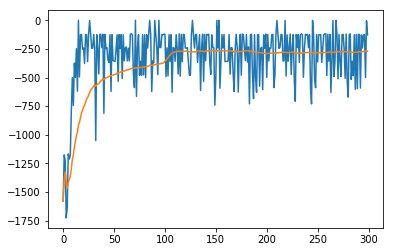

In [37]:
plt.plot(score_log)
plt.plot(average_score_log)

In [20]:
torch.save(actor.state_dict(), "{}_actor_model.pth".format(env_name))
torch.save(critic.state_dict(), "{}_critic_model.pth".format(env_name))

## Watch

In [ ]:
for episode in range(3):
    state = env.reset()
    score = 0
    input()

    for t in range(max_t):
        action = actor.act(state, add_noise=False)
        next_state, reward, done, _ = env.step(action)
        env.render()
        
        score += reward
        
        if done:
            print(score)
            break;

env.close()